# Import the dependencies

We are going to use only numpy for the execution of Neural Network and those are going to fully connected network.
Torch and matplot are going to be used for importing dataset and visualising the same

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch

# Intialization of Layers and Nodes
We need a function that takes the architecture of the network(i.e., the number of layers and nodes in each layer) and initializes the weights and biases

In [2]:

# Initialize the parameters for the neural network
def initialize_parameters(layer_dims):
    np.random.seed(1)  # for reproducibility
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters


Define activation function such as ReLu, sigmoid, tanh and softmax and their derivatives
1. Sigmoid Function: $\sigma(Z)=\frac{1}{1+e^{-Z}}$
2. ReLU function: $ReLU(z)=\max(0,z)$
3. Tanh Function: $tanh(z)=\frac{e^z-e^{-z}}{e^z+e^{-z}}$
4. Softmax Function: $sofmax(z_i)=\frac{e^{z_i}}{\sum_j e_{z_j}}$


In [3]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    return np.maximum(0, Z)

def tanh(Z):
    return np.tanh(Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def tanh_backward(dA, Z):
    return dA * (1 - np.tanh(Z)**2)

def softmax_backward(dA, Z):
    return dA


In [4]:
activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh,
    "softmax": softmax
    }

activation_functions_backward = {
    "sigmoid": sigmoid_backward,
    "relu": relu_backward,
    "tanh": tanh_backward,
    "softmax": softmax_backward
    }

# Forward Pass
Use the chosen activation function to pass the information about your datas.
1. $a^{(1)}={w^{(1)}}^Tx+b^{(1)}$
2. $a^{(i)}={w^{(i)}}^T.\sigma(a^{(i-1)})+b^{(i)}$ for $i>1$

In [5]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

def activate_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    elif activation == "tanh":
        A = tanh(Z)
    elif activation == "softmax":
        A = softmax(Z)
    
    activation_cache = Z
    cache = (linear_cache, activation_cache)
    return A, cache

# Loss Function

Create a set of Loss function which you would wish to minimize for your job
1. Mean Squared Error(MSE)
Mean Square error is used for regression problems and is given by $MSE=\frac{1}{m}\sum_{i=1}^{m}(y_i-\hat{y_i})^2$.

For this exercise, we are only going to use mean squared error and try to minimize it.

In [6]:
def mean_squared_error(Y_hat, Y):
    m = Y.shape[1]
    return np.sum((Y_hat - Y)**2) / (2 * m)

def mean_squared_error_backward(Y_hat, Y):
    m = Y.shape[1]
    return (Y_hat - Y) / m

# Cross-entropy loss and its derivative
def cross_entropy_loss(AL, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(AL + 1e-8)) / m  # Adding epsilon for numerical stability
    return cost

def cross_entropy_loss_backward(AL, Y):
    return AL - Y


# Backward Propagation

Implement the backward pass using the derivatives of the activation functions and the MSE Loss!
Backward Propagation involves computing the gradients of the loss function with respect to the parameters of the neural network. These gradients are then used to update the parameters. We will use the derivative of the activation functions and the MSE loss we 've implemented

In [7]:
#linear backward step
def linear_backward(dz, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dz, A_prev.T) / m
    db = np.sum(dz, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

#activation_backward
def activate_backward(dz, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dA = sigmoid_backward(dz, activation_cache)
    elif activation == "relu":
        dA = relu_backward(dz, activation_cache)
    elif activation == "tanh":
        dA = tanh_backward(dz, activation_cache)
    elif activation == "softmax":
        dA = softmax_backward(dz, activation_cache)
    
    return linear_backward(dA, linear_cache)

# Full backward Propagation
def backward_propagation(Y_hat, Y, caches, activations):
    grads = {}
    L = len(caches) # the number of layers
    m = Y.shape[1] # number of samples
    Y = Y.reshape(Y_hat.shape) # after this line, Y is the same shape as Y_hat

    # Initializing the backpropagation
    dA = mean_squared_error_backward(Y_hat, Y)

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = activate_backward(dA, current_cache, activations[L - 1])

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activate_backward(grads["dA" + str(l + 2)], current_cache, activations[l])
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
    

# Optimizers

This might be the most important step of this whole setup since everything depends on this small step.

1. Stochastic Gradient Descent(SGD)
2. Momentum
3. RMSprop
4. Adam

Put the formulas for all these optimizers later!

In [8]:
# Update the parameters using gradient descent
def update_parameters_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters

# Update the parameters using Momentum Optimizer
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v

def update_parameters_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        parameters["W" + str(l + 1)] -= learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * v["db" + str(l + 1)]
    return parameters, v

# Update the parameters using RMSprop Optimizer
def initialize_rmsprop(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    s = {}
    for l in range(L):
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return s

def update_parameters_rmsprop(parameters, grads, s, beta, learning_rate, epsilon=1e-8):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        s["dW" + str(l + 1)] = beta * s["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]**2
        s["db" + str(l + 1)] = beta * s["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]**2
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)] / np.sqrt(s["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)] / np.sqrt(s["db" + str(l + 1)] + epsilon)
    return parameters, s

# Update the parameters using Adam Optimizer
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v, s

def update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2 # number of layers in the neural networks
    v_corrected = {}
    s_corrected = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - beta1**t)
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - beta1**t)
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * grads["dW" + str(l + 1)]**2
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * grads["db" + str(l + 1)]**2
        
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - beta2**t)
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - beta2**t)
        
        parameters["W" + str(l + 1)] -= learning_rate * v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)
        parameters["b" + str(l + 1)] -= learning_rate * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)
    
    return parameters, v, s

# Training Loop
Training loop will combine all the components which has been implemented till now to train the neural network on a given dataset.

In [9]:
def nnlayer(X,Y, layer_dims, activations, optimizer, learning_rate, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters(layer_dims)
    
    if optimizer == "sgd":
        pass
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "rmsprop":
        s = initialize_rmsprop(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(num_epochs):
        # Forward propagation
        A = X
        caches = []
        for l in range(1, len(layer_dims) - 1):
            A_prev = A
            A, cache = activate_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activations[l - 1])
            caches.append(cache)
        
        # Output layer
        Y_hat, cache = activate_forward(A, parameters["W" + str(len(layer_dims) - 1)], parameters["b" + str(len(layer_dims) - 1)], activations[-1])
        caches.append(cache)
        
        # Compute cost
        cost = mean_squared_error(Y_hat, Y)
        entropy_cost = cross_entropy_loss(Y_hat, Y)
        
        # Backward propagation
        grads = backward_propagation(Y_hat, Y, caches, activations)
        
        # Update parameters
        if optimizer == "sgd":
            parameters = update_parameters_sgd(parameters, grads, learning_rate)
        elif optimizer == "momentum":
            parameters, v = update_parameters_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "rmsprop":
            parameters, s = update_parameters_rmsprop(parameters, grads, s, beta, learning_rate, epsilon)
        elif optimizer == "adam":
            t = i + 1
            parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)
        
        # Print the cost every 100 epochs
        if print_cost and i % 100 == 0:
            print(f"Cost after epoch {i}: {cost}")
        if i % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

## Import dependencies on dataset

In [10]:
from keras.datasets import mnist
from keras.utils import to_categorical

2024-07-21 14:54:46.350373: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 14:54:46.424422: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 14:54:46.500747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 14:54:46.560375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 14:54:46.579853: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 14:54:46.696037: I tensorflow/core/platform/cpu_feature_gu

In [11]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Normalize the data

# Normalize the data
X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0

# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train).T
Y_test = to_categorical(Y_test).T

# Take a subset of the data, may be take 1000 to test the network and test it in 200
X_train = X_train[:, :1000]
Y_train = Y_train[:, :1000]
X_test = X_test[:, :200]
Y_test = Y_test[:, :200]

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (784, 1000)
Y_train shape: (10, 1000)
X_test shape: (784, 200)
Y_test shape: (10, 200)


Cost after epoch 0: 0.45000429087476446
Cost after epoch 100: 0.4495532558570456
Cost after epoch 200: 0.4493779995020533
Cost after epoch 300: 0.4485990950779462
Cost after epoch 400: 0.42031339744006685
Cost after epoch 500: 0.2679737281366171
Cost after epoch 600: 0.15372647689122995
Cost after epoch 700: 0.10158285434250983
Cost after epoch 800: 0.07213526647839617
Cost after epoch 900: 0.04937304390418787
Cost after epoch 1000: 0.03219473011328859
Cost after epoch 1100: 0.0201914994313397
Cost after epoch 1200: 0.012435347089278202
Cost after epoch 1300: 0.007584355619090348
Cost after epoch 1400: 0.004680227247664852
Cost after epoch 1500: 0.0029775516636769577
Cost after epoch 1600: 0.001964719314703622
Cost after epoch 1700: 0.0013458021498628967
Cost after epoch 1800: 0.0009532407979277462
Cost after epoch 1900: 0.0006961572652330133


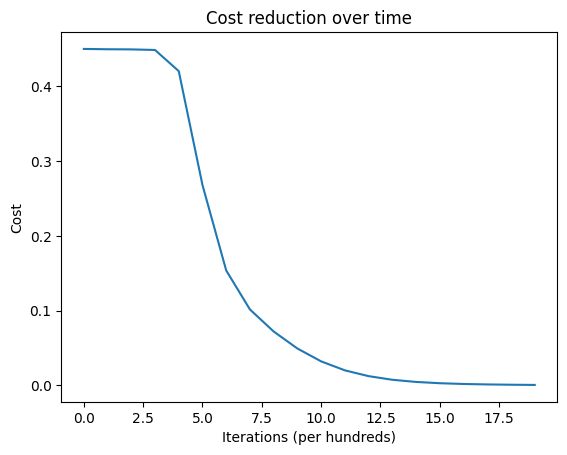

In [17]:
layer_dims = [784, 128, 64, 10]  # 784 input nodes, 2 hidden layers with 128 and 64 nodes, 10 output nodes
activations = ["relu", "relu", "softmax"]

# Train the model
parameters, costs = nnlayer(X_train,Y_train, layer_dims, activations, optimizer="adam", learning_rate=0.01, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=2000, print_cost=True)

# Plotting the cost function
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (per hundreds)')
plt.title('Cost reduction over time')
plt.show()


In [18]:
def predict(X, parameters, activations):
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    caches = []
    
    for l in range(1, L + 1):
        A_prev = A
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A, cache = activate_forward(A_prev, W, b, activations[l-1])
        caches.append(cache)
    
    return A

# Predict on the test set
Y_pred = predict(X_test, parameters, activations)

# Compute accuracy
def compute_accuracy(Y_pred, Y_true):
    predictions = np.argmax(Y_pred, axis=0)
    labels = np.argmax(Y_true, axis=0)
    accuracy = np.mean(predictions == labels)
    return accuracy

accuracy = compute_accuracy(Y_pred, Y_test)
print(f"Test set accuracy: {accuracy * 100:.2f}%")



Test set accuracy: 86.50%


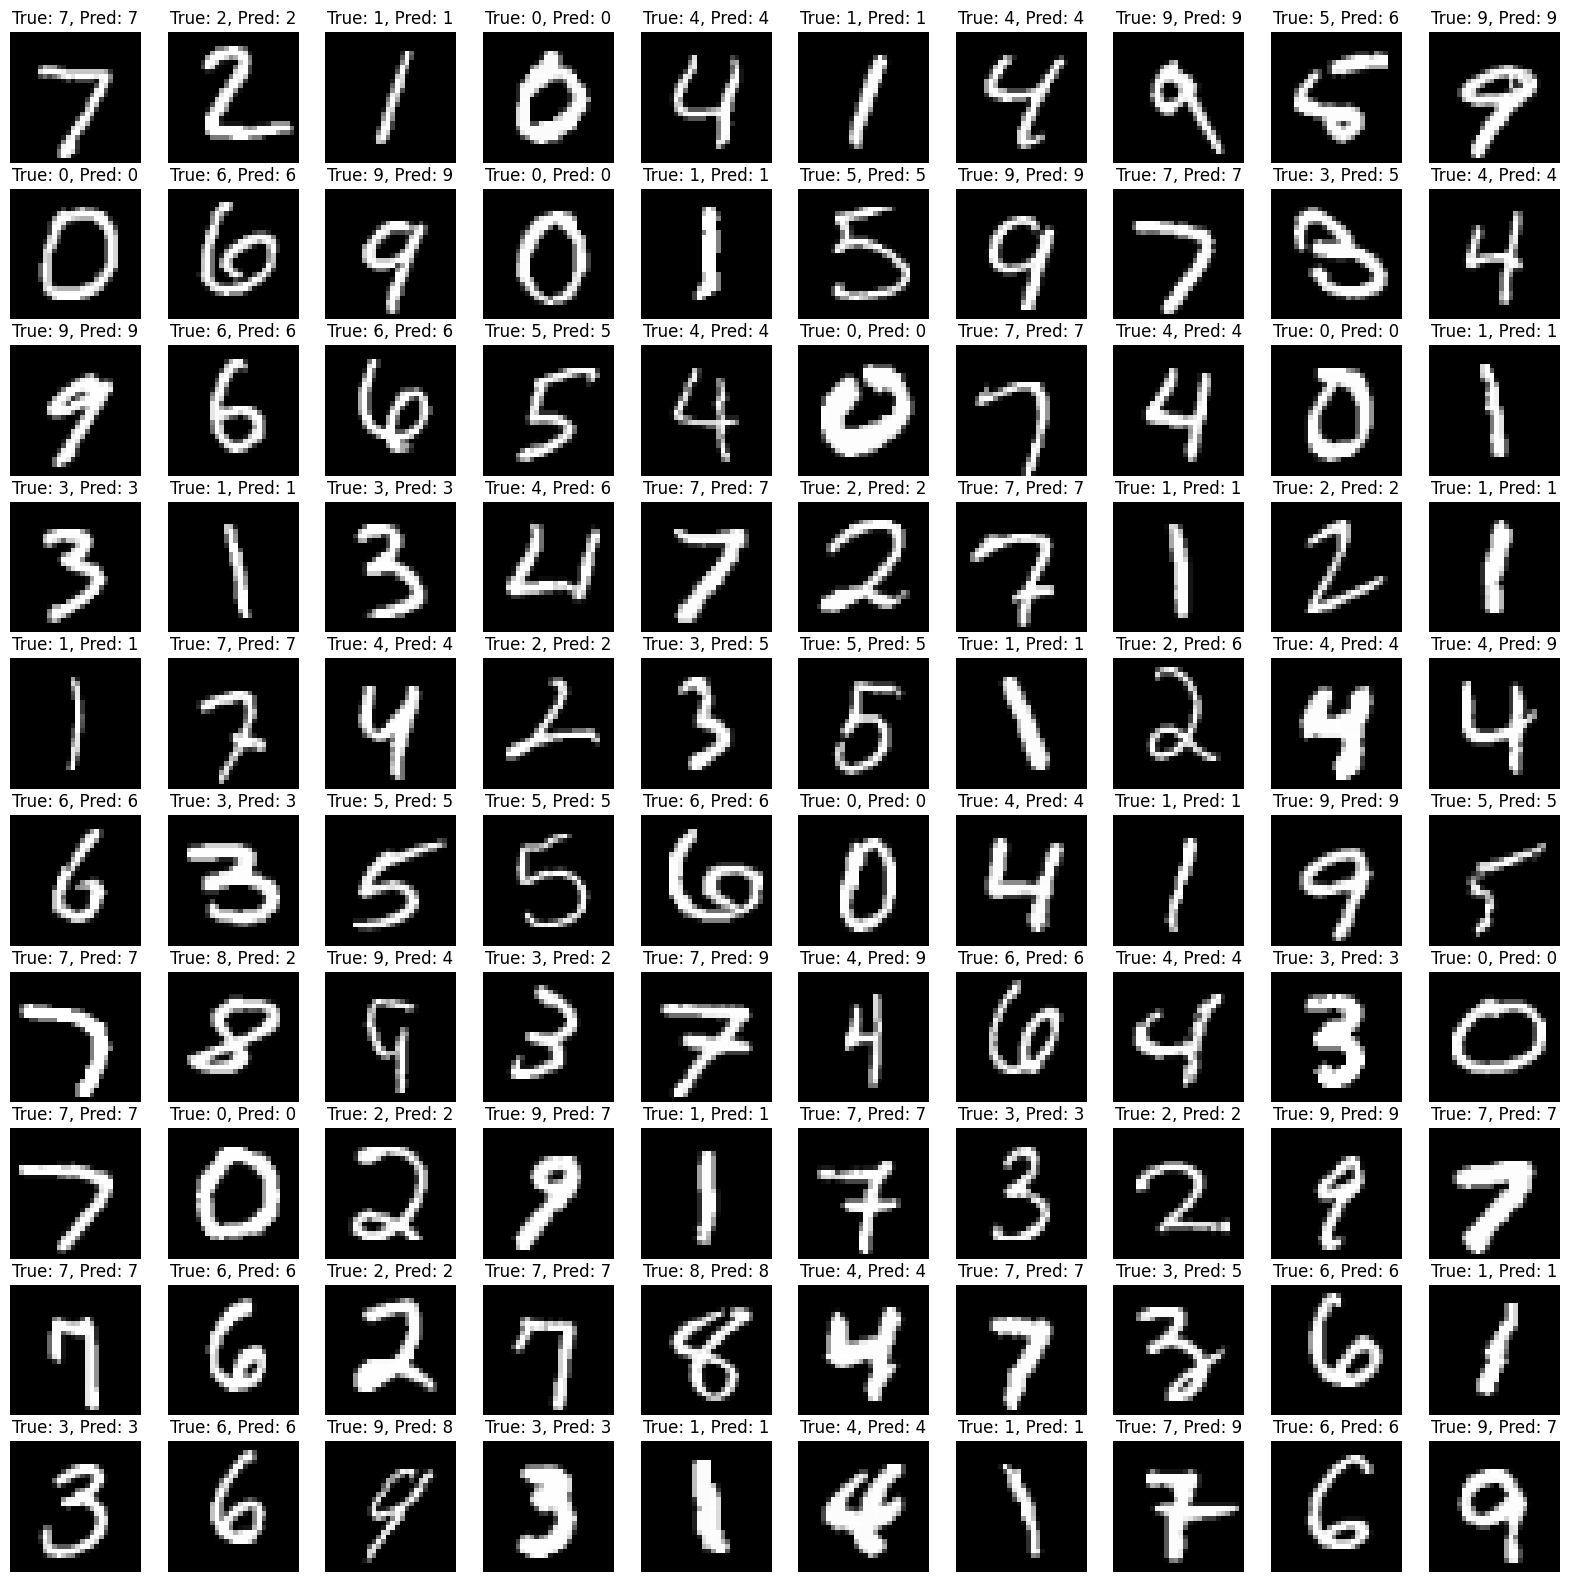

In [19]:
# visualise 100 of the mnist test dataset
# create 10x10 grid of images
# create 10x10 grid of corresponding outputs for the same
# create 10x10 grid of corresponding predictions for the same

def plot_mnist(X, Y_true, Y_pred):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:, i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f"True: {np.argmax(Y_true[:, i])}, Pred: {np.argmax(Y_pred[:, i])}")
    plt.show()

plot_mnist(X_test, Y_test, Y_pred)
